In [1]:
#04.10
random_state = 16

# Imports

In [2]:
!pip install scikit-learn xgboost


In [3]:
!pip install pandas numpy seaborn matplotlib yellowbrick scipy

In [13]:
#imports
from sklearn.ensemble import BaggingRegressor
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt    
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupKFold
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from yellowbrick.regressor import PredictionError, ResidualsPlot
from yellowbrick.style import set_palette
from yellowbrick.style import rcmod
from sklearn.feature_selection import SelectFromModel

# Parameters

In [14]:
num=list(np.logspace(-2, 1, num = 20))
max=1
etas = list(filter(lambda x: x < max, num))
etas

[0.01,
 0.01438449888287663,
 0.0206913808111479,
 0.029763514416313176,
 0.04281332398719394,
 0.06158482110660264,
 0.08858667904100823,
 0.12742749857031335,
 0.18329807108324356,
 0.26366508987303583,
 0.37926901907322497,
 0.5455594781168517,
 0.7847599703514611]

In [15]:
param_xgb = {
    "max_depth" : range(1, 6),
    "eta" : etas
}

In [16]:
param_xgb2 = {
    "max_depth" : range(3, 10),
    "eta" : np.arange(0.1, 0.3, 0.05),
    "colsample_bytree" : np.arange(0.5, 1, 0.1),
    "lambda" : range(1, 10),
    "alpha" : np.arange(0, 1, 0.2)
}

In [17]:
parameters_dtc = {
    'max_depth':range(1, 15),
}

In [18]:
parameters_knr = {
    'n_neighbors':range(1, 80),
}

In [19]:
parameters_enet = {
    "alpha" : np.delete(np.linspace(0, 1, 200), 0)
}

# Data

In [20]:
train = pd.read_csv("protherm_train.csv", index_col = 0)
train.head()

,Length,Tm_C,AA,AR,RA,AN,NA,AD,DA,AC,...,epsilon,oxidized-reduced,de_mul,ivywrel,methyl_groups,tighter_packing,hydrophobic,beta_branched,h_bond_form,vip
0,468,57.83,0.014989,0.002141,0.010707,0.006424,0.000000,0.004283,0.004283,0.000000,...,59250,125,0.004191,0.399573,0.393162,0.279915,0.316239,0.183761,0.096154,0.170940
1,602,46.77,0.018303,0.001664,0.004992,0.008319,0.003328,0.008319,0.003328,0.000000,...,63830,625,0.004249,0.362126,0.382060,0.244186,0.302326,0.166113,0.091362,0.142857
2,447,58.78,0.006726,0.008969,0.002242,0.008969,0.006726,0.006726,0.006726,0.004484,...,42400,250,0.002948,0.351230,0.393736,0.259508,0.333333,0.170022,0.071588,0.154362
3,206,66.59,0.034146,0.004878,0.000000,0.019512,0.014634,0.004878,0.004878,0.000000,...,43430,0,0.003676,0.330097,0.364078,0.247573,0.320388,0.121359,0.063107,0.121359
5,797,47.89,0.011307,0.002513,0.003769,0.006281,0.001256,0.008794,0.003769,0.002513,...,148740,375,0.003671,0.388959,0.381430,0.259724,0.343789,0.160602,0.084065,0.159348


In [21]:
test = pd.read_csv("protherm_test.csv", index_col = 0)
test.head()

,Length,Tm_C,AA,AR,RA,AN,NA,AD,DA,AC,...,epsilon,oxidized-reduced,de_mul,ivywrel,methyl_groups,tighter_packing,hydrophobic,beta_branched,h_bond_form,vip
4,761,44.79,0.010526,0.001316,0.005263,0.003947,0.003947,0.002632,0.007895,0.003947,...,88590,625,0.004051,0.388962,0.369251,0.239159,0.320631,0.168200,0.106439,0.157687
16,520,46.49,0.003854,0.009634,0.011561,0.000000,0.001927,0.007707,0.007707,0.001927,...,20860,750,0.004530,0.396154,0.398077,0.251923,0.340385,0.144231,0.103846,0.150000
18,453,44.71,0.017699,0.013274,0.004425,0.002212,0.000000,0.008850,0.011062,0.002212,...,40340,375,0.003250,0.388521,0.419426,0.298013,0.331126,0.167770,0.086093,0.167770
19,428,48.48,0.014052,0.000000,0.007026,0.004684,0.002342,0.004684,0.002342,0.002342,...,29910,250,0.003799,0.364486,0.411215,0.266355,0.364486,0.156542,0.060748,0.156542
21,391,49.10,0.015385,0.002564,0.005128,0.010256,0.007692,0.000000,0.007692,0.000000,...,32430,125,0.003035,0.352941,0.391304,0.283887,0.373402,0.132992,0.046036,0.168798


In [22]:
groups = pd.read_csv("protherm_groups.csv", index_col = 0)
groups.head()

,cluster#
0,3092
1,0
2,1
3,734
5,1396


In [23]:
X_train = train.drop(columns=['Tm_C'])
y_train = train['Tm_C']
X_test = test.drop(columns=['Tm_C'])
y_test = test['Tm_C']

In [24]:
X_train.shape, X_test.shape

((5338, 446), (1334, 446))

In [16]:
X_train.head()

,Length,AA,AR,RA,AN,NA,AD,DA,AC,CA,...,epsilon,oxidized-reduced,de_mul,ivywrel,methyl_groups,tighter_packing,hydrophobic,beta_branched,h_bond_form,vip
0,468,0.014989,0.002141,0.010707,0.006424,0.000000,0.004283,0.004283,0.000000,0.000000,...,59250,125,0.004191,0.399573,0.393162,0.279915,0.316239,0.183761,0.096154,0.170940
1,602,0.018303,0.001664,0.004992,0.008319,0.003328,0.008319,0.003328,0.000000,0.000000,...,63830,625,0.004249,0.362126,0.382060,0.244186,0.302326,0.166113,0.091362,0.142857
2,447,0.006726,0.008969,0.002242,0.008969,0.006726,0.006726,0.006726,0.004484,0.002242,...,42400,250,0.002948,0.351230,0.393736,0.259508,0.333333,0.170022,0.071588,0.154362
3,206,0.034146,0.004878,0.000000,0.019512,0.014634,0.004878,0.004878,0.000000,0.000000,...,43430,0,0.003676,0.330097,0.364078,0.247573,0.320388,0.121359,0.063107,0.121359
5,797,0.011307,0.002513,0.003769,0.006281,0.001256,0.008794,0.003769,0.002513,0.001256,...,148740,375,0.003671,0.388959,0.381430,0.259724,0.343789,0.160602,0.084065,0.159348


# Feature Preselection
## Finding Correlation


In [25]:
corrs = {}
for i in X_train.columns:
    corr = y_train.corr(X_train[i])
    corrs[i] = corr

In [26]:
dict(sorted(corrs.items(), key=lambda item: item[1], reverse=True))

{'EA': 0.44528522297636625,
 'ivywrel': 0.40863468205905223,
 'LE': 0.38537082928188443,
 'AL': 0.3720579768431333,
 'EV': 0.35064590024298203,
 'EG': 0.33697691679693254,
 'R': 0.3296302729105946,
 'h_bond_form': 0.32446547920317087,
 'L': 0.31506418643795253,
 'RL': 0.3147499261598726,
 'AR': 0.3097000926117997,
 'PE': 0.3066964365310396,
 'RA': 0.2949789255919945,
 'GL': 0.28841060327868806,
 'E': 0.28267327741291476,
 'LG': 0.27315395304937645,
 'RV': 0.2721154339302028,
 'LA': 0.25968098619591345,
 'LR': 0.2553254280170343,
 'VR': 0.2546527462794838,
 'VL': 0.23837389959332037,
 'ER': 0.23420364148341116,
 'P': 0.23251427195935223,
 'VE': 0.220380295131394,
 'G': 0.21803619750610748,
 'RE': 0.2149451231695821,
 'V': 0.214181329614721,
 'PL': 0.2106202341422465,
 'GV': 0.209228216540372,
 'LL': 0.20902133048151764,
 'GR': 0.20882513835629826,
 'RP': 0.20817512119083975,
 'A': 0.2050515555396656,
 'LP': 0.2027848138294013,
 'AY': 0.20219166951073628,
 'tighter_packing': 0.1943410873

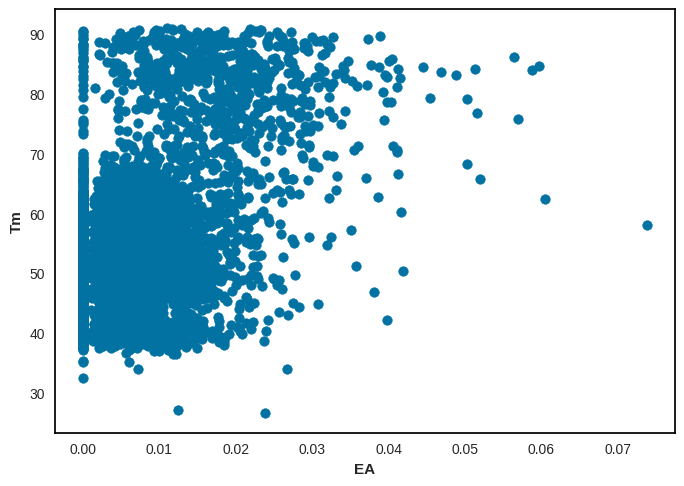

In [28]:
plt.rcParams["axes.edgecolor"] = 'black'
plt.grid(False)
plt.ylabel('Tm', fontweight='bold')
plt.xlabel('EA', fontweight='bold')
plt.scatter(X_train['EA'], y_train)

## Elastic Net

In [27]:
enet = ElasticNet(random_state=random_state)
gs_enet = GridSearchCV(enet, parameters_enet, scoring = ['neg_mean_squared_error'], refit = 'neg_mean_squared_error', cv = GroupKFold(n_splits=5), return_train_score=True, n_jobs=-1)
gs_enet.fit(X_train, y_train, groups = groups)

GridSearchCV(cv=GroupKFold(n_splits=5), estimator=ElasticNet(random_state=16),
             n_jobs=-1,
             param_grid={'alpha': array([0.00502513, 0.01005025, 0.01507538, 0.0201005 , 0.02512563,
       0.03015075, 0.03517588, 0.04020101, 0.04522613, 0.05025126,
       0.05527638, 0.06030151, 0.06532663, 0.07035176, 0.07537688,
       0.08040201, 0.08542714, 0.09045226, 0.09547739, 0.10050251,
       0.10552764, 0.1105...
       0.85929648, 0.86432161, 0.86934673, 0.87437186, 0.87939698,
       0.88442211, 0.88944724, 0.89447236, 0.89949749, 0.90452261,
       0.90954774, 0.91457286, 0.91959799, 0.92462312, 0.92964824,
       0.93467337, 0.93969849, 0.94472362, 0.94974874, 0.95477387,
       0.95979899, 0.96482412, 0.96984925, 0.97487437, 0.9798995 ,
       0.98492462, 0.98994975, 0.99497487, 1.        ])},
             refit='neg_mean_squared_error', return_train_score=True,
             scoring=['neg_mean_squared_error'])

In [21]:
enet = gs_enet.best_estimator_
enet.fit(X_train, y_train)

y_pred_train = enet.predict(X_train)
print("elastic train RMSE: {0}, R2: {1}, PCC: {2}".format(mean_squared_error(y_train,y_pred_train,  squared = False),
                                                 r2_score(y_train, y_pred_train), pearsonr(y_train,y_pred_train)))
y_test_enet = enet.predict(X_test)
print("elastic test RMSE: {0}, R2: {1}, PCC: {2}".format(mean_squared_error(y_test, y_test_enet, squared = False),
                                                r2_score(y_test, y_test_enet), pearsonr(y_test, y_test_enet)))

elastic train RMSE: 10.295566569920943, R2: 0.3288876657870511, PCC: PearsonRResult(statistic=0.6058293793884926, pvalue=0.0)
elastic test RMSE: 10.427985007798345, R2: 0.3010231441884468, PCC: PearsonRResult(statistic=0.5773517220873495, pvalue=1.9953122794056e-119)


In [22]:
print(gs_enet.best_estimator_)

ElasticNet(alpha=0.005025125628140704, random_state=16)


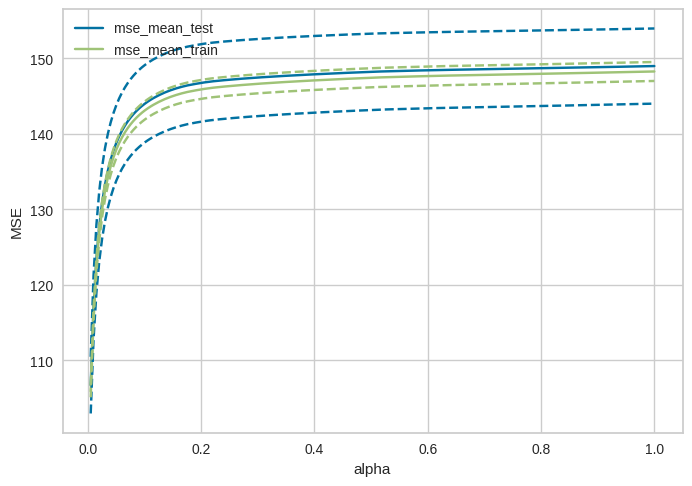

In [23]:
scores_mean_test = gs_enet.cv_results_['mean_test_neg_mean_squared_error']*-1
scores_mean_train = gs_enet.cv_results_['mean_train_neg_mean_squared_error']*-1
scores_std_test = gs_enet.cv_results_['std_test_neg_mean_squared_error']*-1
scores_std_train = gs_enet.cv_results_['std_train_neg_mean_squared_error']*-1
range_depth = parameters_enet['alpha']

plt.figure()
plt.plot(range_depth, scores_mean_test, 'b')
plt.plot(range_depth, scores_mean_train, 'g')

plt.plot(range_depth, scores_mean_test + scores_std_test, 'b--')
plt.plot(range_depth, scores_mean_test - scores_std_test, 'b--')

plt.plot(range_depth, scores_mean_train + scores_std_train, 'g--')
plt.plot(range_depth, scores_mean_train - scores_std_train, 'g--')

plt.xlabel('alpha')
plt.ylabel('MSE')
plt.legend(['mse_mean_test', 'mse_mean_train'], loc = 'upper left')
plt.show()


## Optimal alpha

In [17]:
alphas = np.delete(np.linspace(0, 1, 200), 0)

non_zero_count = []
zero_count = []
for i in alphas:
    enet = ElasticNet(alpha=i,random_state=random_state)
    enet.fit(X_train, y_train)
    pred = enet.predict(X_test)
    arr = np.array(enet.coef_)
    non_zero = np.count_nonzero(arr)
    zero = len(arr) - np.count_nonzero(arr)
    non_zero_count.append(non_zero)
    zero_count.append(zero)


In [18]:
alphas[:15]

array([0.00502513, 0.01005025, 0.01507538, 0.0201005 , 0.02512563,
       0.03015075, 0.03517588, 0.04020101, 0.04522613, 0.05025126,
       0.05527638, 0.06030151, 0.06532663, 0.07035176, 0.07537688])

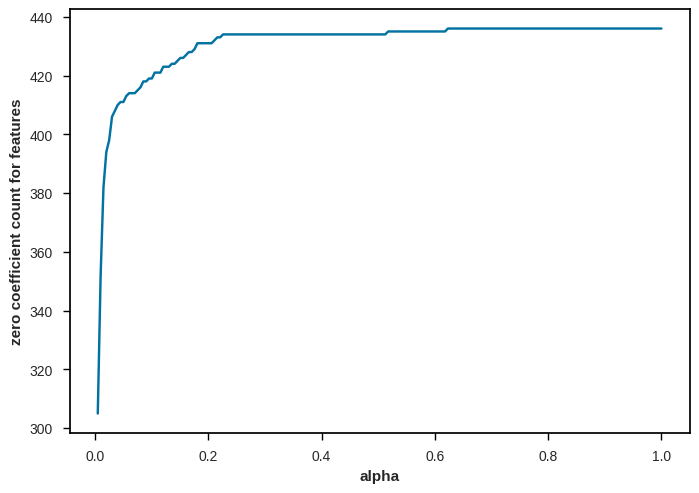

In [19]:
plt.rcParams["axes.edgecolor"] = 'black'
plt.grid(False)


plt.tick_params(axis="x", direction="out", length = 5, color = 'black')
plt.tick_params(axis="y", direction="out", length = 5, color = 'black')

plt.plot(alphas, zero_count, 'b')

plt.xlabel('alpha', fontweight='bold')
plt.ylabel('zero coefficient count for features', fontweight='bold')
plt.savefig('EN_P2.png')
plt.show()

In [20]:
enet = ElasticNet(alpha=0.00502513, random_state=random_state)
enet.fit(X_train, y_train)
arr = np.array(enet.coef_)

d = {'col1':arr, 'col2':X_train.columns}
coef = pd.DataFrame(data = d)
coef

,col1,col2
0,-0.001448,Length
1,-0.085360,AA
2,1.964442,AR
3,1.739570,RA
4,-0.079165,AN
...,...,...
440,7.389936,tighter_packing
441,9.956660,hydrophobic
442,-17.453455,beta_branched
443,14.218017,h_bond_form


In [21]:
predicted_train = enet.predict(X_train)
predicted_test = enet.predict(X_test)
print("EN train RMSE: {0}, R2: {1}, PCC: {2}".format(mean_squared_error(y_train, predicted_train, squared=False),
                                           r2_score(y_train, predicted_train), pearsonr(y_train, predicted_train)))
print("EN test RMSE: {0}, R2: {1}, PCC: {2}".format(mean_squared_error(y_test, predicted_test, squared = False),
                                                r2_score(y_test, predicted_test), pearsonr(y_test, predicted_test)))

EN train RMSE: 10.295567132526969, R2: 0.32888759244055754, PCC: PearsonRResult(statistic=0.6058293328228245, pvalue=0.0)
EN test RMSE: 10.427985561597495, R2: 0.301023069947297, PCC: PearsonRResult(statistic=0.5773516669682475, pvalue=1.9954393404825794e-119)


In [22]:
coef_0 = coef.loc[coef['col1'] == 0]
zero_features = coef_0['col2']
zero_features


8             AC
9             CA
10            AQ
11            QA
14            AG
         ...    
419            W
433    avg_sheet
434     avg_coil
437       de_mul
444          vip
Name: col2, Length: 305, dtype: object

In [23]:
zero_features.to_csv("zero_features.csv", index = False)

In [24]:
zero_features = pd.read_csv("zero_features.csv")
zero_features.head()

,col2
0,AC
1,CA
2,AQ
3,QA
4,AG


In [25]:
zero_features.shape

(305, 1)

In [26]:
zero_features = zero_features['col2'].to_list()

In [27]:
X_train = X_train.drop(columns=zero_features)
X_test = X_test.drop(columns=zero_features)
X_train.shape, X_test.shape

((5338, 140), (1334, 140))

# Decision Tree

In [28]:
dtc = DecisionTreeRegressor(random_state=random_state)
grid_dtc = GridSearchCV(dtc, parameters_dtc, scoring=['neg_root_mean_squared_error'], refit='neg_root_mean_squared_error', cv=GroupKFold(n_splits = 5),
                    return_train_score=True, n_jobs=-1, error_score='raise')
grid_dtc.fit(X_train, y_train, groups = groups)
print(grid_dtc.best_estimator_)

DecisionTreeRegressor(max_depth=4, random_state=16)


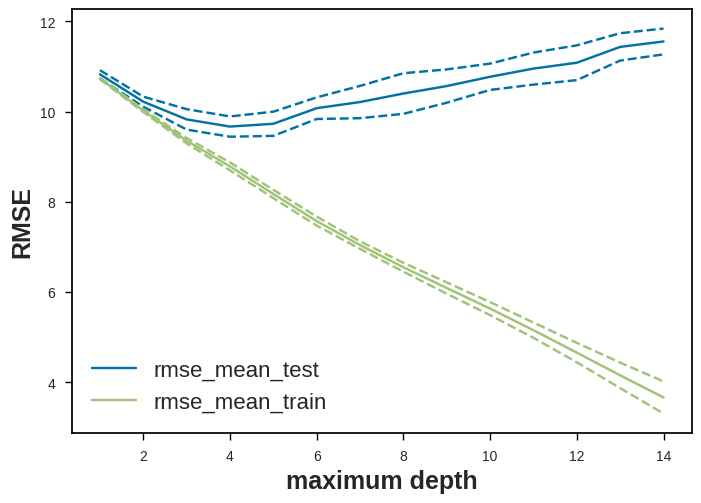

In [44]:
scores_mean_test = grid_dtc.cv_results_['mean_test_neg_root_mean_squared_error']*-1
scores_mean_train = grid_dtc.cv_results_['mean_train_neg_root_mean_squared_error']*-1
scores_std_test = grid_dtc.cv_results_['std_test_neg_root_mean_squared_error']*-1
scores_std_train = grid_dtc.cv_results_['std_train_neg_root_mean_squared_error']*-1
range_depth = parameters_dtc['max_depth']


plt.figure()
plt.rcParams["axes.edgecolor"] = 'black'
plt.grid(False)
plt.tick_params(axis="x", direction="out", length = 5, color = 'black')
plt.tick_params(axis="y", direction="out", length = 5, color = 'black')
plt.plot(range_depth, scores_mean_test, 'b')
plt.plot(range_depth, scores_mean_train, 'g')

plt.rcParams["axes.edgecolor"] = 'black'
plt.rc('font', size=26)   
plt.grid(False)
plt.tick_params(axis="x", direction="out", length = 5, color = 'black')
plt.tick_params(axis="y", direction="out", length = 5, color = 'black')

plt.plot(range_depth, scores_mean_test + scores_std_test, 'b--')
plt.plot(range_depth, scores_mean_test - scores_std_test, 'b--')

plt.plot(range_depth, scores_mean_train + scores_std_train, 'g--')
plt.plot(range_depth, scores_mean_train - scores_std_train, 'g--')

plt.xlabel('maximum depth', fontweight='bold', fontsize = 18)
plt.ylabel('RMSE', fontweight='bold', fontsize = 18)
plt.legend(['rmse_mean_test', 'rmse_mean_train'], loc = 'lower left', fontsize = 16)
plt.savefig('DTC_P2.png')
plt.show()

In [24]:
dtc = grid_dtc.best_estimator_
dtc.fit(X_train, y_train)

y_pred_train = dtc.predict(X_train)
print("decision train RMSE: {0}, R2: {1}, PCC: {2}".format(mean_squared_error(y_train,y_pred_train,  squared = False),
                                                 r2_score(y_train, y_pred_train), pearsonr(y_train, y_pred_train)))
y_pred_test = dtc.predict(X_test)
print("decision test RMSE: {0}, R2: {1}, PCC: {2}".format(mean_squared_error(y_test, y_pred_test, squared = False),
                                                r2_score(y_test, y_pred_test), pearsonr(y_test, y_pred_test)))

decision train RMSE: 8.801984944552038, R2: 0.5094808563877553, PCC: PearsonRResult(statistic=0.713779277079235, pvalue=0.0)
decision test RMSE: 9.733073542478694, R2: 0.39107751735571195, PCC: PearsonRResult(statistic=0.6319944075335427, pvalue=1.1697134764049642e-149)


# KNN

In [45]:
knr = KNeighborsRegressor()
grid_knr = GridSearchCV(knr, parameters_knr, scoring = ['neg_root_mean_squared_error'], refit = 'neg_root_mean_squared_error', cv = GroupKFold(n_splits=5), return_train_score=True, n_jobs=-1, error_score='raise')
grid_knr.fit(X_train, y_train, groups = groups)
print(grid_knr.best_estimator_)

KNeighborsRegressor(n_neighbors=20)


In [46]:
knr = grid_knr.best_estimator_
knr.fit(X_train, y_train)

y_pred_train = knr.predict(X_train)
print("knr train RMSE: {0}, R2: {1}, PCC: {2}".format(mean_squared_error(y_train,y_pred_train,  squared = False),
                                                 r2_score(y_train, y_pred_train), pearsonr(y_train, y_pred_train)))
y_pred_test = knr.predict(X_test)
print("knr test RMSE: {0}, R2: {1}, PCC: {2}".format(mean_squared_error(y_test, y_pred_test, squared = False),
                                                r2_score(y_test, y_pred_test), pearsonr(y_test, y_pred_test)))

knr train RMSE: 11.847060681549115, R2: 0.11138028461066596, PCC: PearsonRResult(statistic=0.3342850251614942, pvalue=1.6221894085144307e-139)
knr test RMSE: 12.372879007700352, R2: 0.015980892171369332, PCC: PearsonRResult(statistic=0.1881544027987184, pvalue=4.278425508147372e-12)


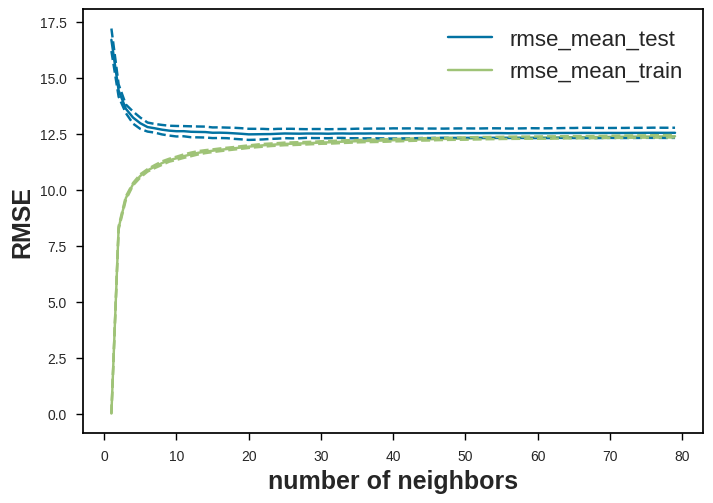

In [47]:
scores_mean_test = grid_knr.cv_results_['mean_test_neg_root_mean_squared_error']*-1
scores_mean_train = grid_knr.cv_results_['mean_train_neg_root_mean_squared_error']*-1
scores_std_test = grid_knr.cv_results_['std_test_neg_root_mean_squared_error']*-1
scores_std_train = grid_knr.cv_results_['std_train_neg_root_mean_squared_error']*-1
range_depth = parameters_knr['n_neighbors']

plt.figure()

plt.rcParams["axes.edgecolor"] = 'black'
plt.grid(False)
plt.tick_params(axis="x", direction="out", length = 5, color = 'black')
plt.tick_params(axis="y", direction="out", length = 5, color = 'black')

plt.plot(range_depth, scores_mean_test, 'b')
plt.plot(range_depth, scores_mean_train, 'g')

plt.plot(range_depth, scores_mean_test + scores_std_test, 'b--')
plt.plot(range_depth, scores_mean_test - scores_std_test, 'b--')

plt.plot(range_depth, scores_mean_train + scores_std_train, 'g--')
plt.plot(range_depth, scores_mean_train - scores_std_train, 'g--')

plt.xlabel('number of neighbors', fontweight='bold', fontsize = 18)
plt.ylabel('RMSE', fontweight='bold', fontsize = 18)
plt.legend(['rmse_mean_test', 'rmse_mean_train'], loc = 'upper right', fontsize = 16)
plt.savefig('KNN_P2.png')

plt.show()

# MLPRegression

In [45]:
mlpr = make_pipeline(
    MinMaxScaler(),
    MLPRegressor(
        hidden_layer_sizes=(64, 32), early_stopping=True, random_state=random_state, max_iter = 500
    ),
)
bag = BaggingRegressor(estimator=mlpr, n_estimators=20, random_state=random_state)
bag.fit(X_train, y_train)

y_pred_train = bag.predict(X_train)
print("mlpr train RMSE: {0}, R2: {1}, PCC: {2}".format(mean_squared_error(y_train, y_pred_train, squared=False),
                                             r2_score(y_train, y_pred_train), pearsonr(y_train, y_pred_train)))

y_pred_test = bag.predict(X_test)
print("mlpr test RMSE: {0}, R2: {1}, PCC: {2}".format(mean_squared_error(y_test, y_pred_test, squared=False),
                                            r2_score(y_test, y_pred_test), pearsonr(y_test, y_pred_test)))

mlpr train RMSE: 6.506460609130395, R2: 0.7319694310027733, PCC: PearsonRResult(statistic=0.8572787361926638, pvalue=0.0)
mlpr test RMSE: 7.672546181434647, R2: 0.621608805086417, PCC: PearsonRResult(statistic=0.7884285802830892, pvalue=2.2034083987750644e-283)


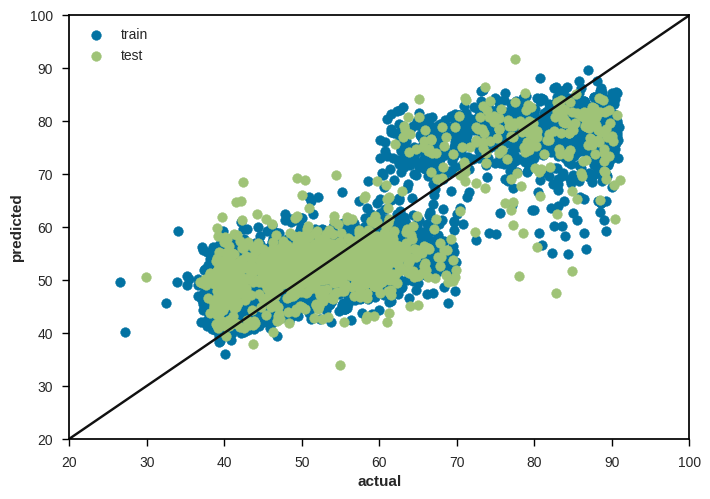

In [46]:
x = np.linspace(0, 100, 110)
plt.rcParams["axes.edgecolor"] = 'black'
#plt.axis('equal')
plt.xlim(20,100)
plt.ylim(20,100)
plt.grid(False)

plt.ylabel('predicted Tm', fontweight='bold')
plt.xlabel('actual Tm', fontweight='bold')
plt.plot(x,x,'k-') # identity line
plt.scatter(y_train, y_pred_train, label = 'train')
plt.scatter(y_test, y_pred_test, label = 'test')

plt.tick_params(axis="x", direction="out", length = 5, color = 'black')
plt.tick_params(axis="y", direction="out", length = 5, color = 'black')
plt.legend()
plt.savefig('mlp_2.png')
plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BaggingRegressor was fitted with feature names
  warnings.warn(


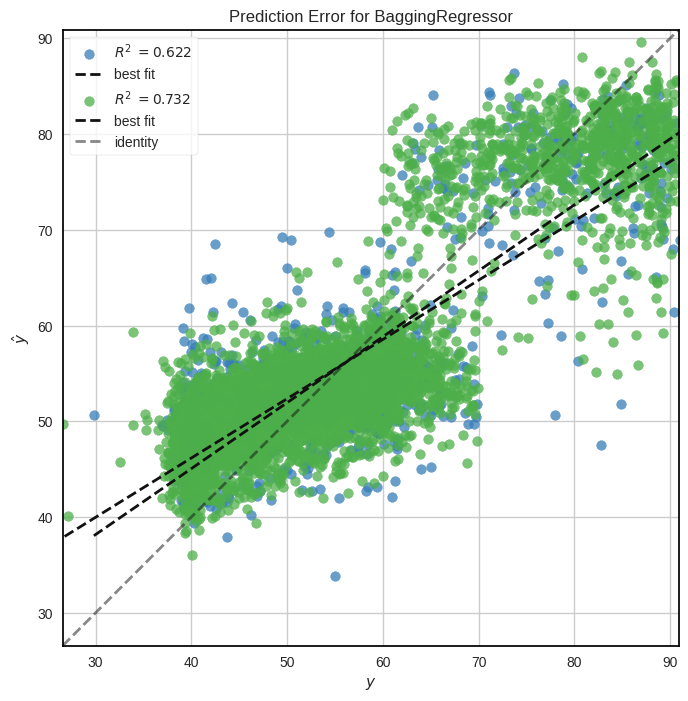

<Axes: title={'center': 'Prediction Error for BaggingRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [47]:
visualizer = PredictionError(bag, size = (800, 800)) 
# fit visualizer on training data
set_palette('bold')
visualizer.fit(X_train, y_train) 
#Evaluate on test data
visualizer.score(X_test, y_test)
visualizer.score(X_train, y_train)

visualizer.show()

# XGBoost

In [28]:
rs = RandomizedSearchCV(
    XGBRegressor(random_state=random_state), 
    param_distributions=param_xgb, 
    cv=GroupKFold(n_splits=5),
    scoring="neg_root_mean_squared_error", 
    refit = "neg_root_mean_squared_error", 
    n_iter = 100,
    return_train_score=True, 
    error_score='raise',
    n_jobs=-1
)
rs.fit(X_train, y_train, groups = groups)
print(rs.best_estimator_)
#xgb.fit(X_train, y_train)
y_pred_train = rs.predict(X_train)
print("xgbregressor train RMSE: {0}, R2: {1}, PCC: {2}".format(mean_squared_error(y_train,y_pred_train,  squared = False),
                                                    r2_score(y_train, y_pred_train), pearsonr(y_train,y_pred_train)))
y_pred_test = rs.predict(X_test)
print("xgbregressor test RMSE: {0}, R2: {1}, PCC: {2}".format(mean_squared_error(y_test, y_pred_test, squared = False),
                                            r2_score(y_test, y_pred_test), pearsonr(y_test, y_pred_test)))



/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 65 is smaller than n_iter=100. Running 65 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.08858667904100823,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)
xgbregressor train RMSE: 5.134573482791428, R2: 0.8330818872380438, PCC: PearsonRResult(statistic=0.9183140554593167, pvalue=0.0)
xgbregressor test RMSE: 8.292856743268379, R2: 0.5579510881274892, PCC: PearsonRResult(statistic=0.74709998954189

In [29]:
with open("p2_xgb.txt", 'w') as f: 
    for key, value in rs.cv_results_.items(): 
        f.write('%s:%s\n' % (key, value))

In [30]:
np.mean(rs.cv_results_['mean_test_score']), np.mean(rs.cv_results_['mean_train_score'])

(-10.668574875623698, -8.527720612460014)

In [31]:
rs.cv_results_

{'mean_fit_time': array([ 235.66169758,  407.9782146 ,  664.47716198, 1023.50571647,
        1455.456849  ,  232.07947059,  392.46213083,  636.29481707,
        1004.16022215, 1550.84375963,  263.35546021,  417.40911984,
         635.56315937, 1017.43814254, 1554.13603606,  243.615727  ,
         434.01777949,  669.70390282, 1036.37078581, 1567.20215473,
         240.92425666,  421.66438222,  665.43397703, 1025.14265079,
        1567.04603534,  243.91424861,  415.46113157,  648.3243135 ,
         979.31898375, 1501.30071244,  240.89616127,  400.63596935,
         649.25575995,  978.61596737, 1446.36315789,  236.65784588,
         414.66415296,  626.72262754,  977.59717164, 1501.71930957,
         238.29762979,  414.22471948,  628.01739631,  963.96523833,
        1508.07977548,  237.54758482,  407.57511525,  624.80456877,
         956.74104333, 1499.45925946,  236.68614635,  409.38234215,
         625.67967434,  980.76003284, 1469.07714171,  237.17691197,
         407.90271792,  628.114